In [1]:
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time

from linearWaveModels import linear_w_1layer,linear_w_2layer,linear_w_generalized,w_to_zeta,w_to_Tprime

xr.set_options(display_style='text') 

In [2]:
from scipy.integrate import cumtrapz
def plot_streamlines(ax,w,Uz,**plt_kwargs):
    zeta = w_to_zeta(w,Uz)
    for zi in np.linspace(0,9,13):
        ax.plot(w.distance_from_mtn,zi+zeta.sel(altitude=zi,method='nearest'),**plt_kwargs)

We now solve for the linear mountain wave equation with arbitrary wind & static stability:

$$(\partial_z^2 + \partial_x^2)w + l(z)^2 w =0 ~~~~\textrm{where } l(z)^2 := \dfrac{N^2}{U^2}-\dfrac{1}{U}\dfrac{\mathrm{d}^2U}{\mathrm{d}z^2}$$

or, when writing $w(x,z) = \int_{-\infty}^{+\infty}\hat{w}(k,z)e^{ikx}\mathrm{d}k$, 
$$\partial_z^2\hat w + (l(z)^2 - k^2)\hat w =0$$
The lower BC is $\hat w(k,0) = ikU(z=0)\hat h(k)$, and upper BC (from Durran et al 2014) is $\dfrac{\mathrm{d}\hat w}{\mathrm{d}z}(k,z_{top}) - im_{top} \hat w(k,z_{top}) = 0$, where $m_{top}=\sqrt{l(z_{top})^2 - k^2}$, assuming one always has $l(z_{top})^2 > k^2$

We discretize the problem on a uniform z grid.

In [4]:
z=np.linspace(0,9e3,100)
xx = np.arange(-250e3,250.1e3,2e2)
U=10;Nl=0.01047;Nu=Nl*0.24/0.6;H=3000
a=5e3;A=0.6*U/Nl
hx = A*a**2/(xx**2+a**2)
x0 = 8771*20.3
hx_destructive_general = A*a**2/(xx**2+a**2) + A*a**2/((xx-x0)**2+a**2)
x0 = 8613.26*20.44
hx_destructive_2layer = A*a**2/(xx**2+a**2) + A*a**2/((xx-x0)**2+a**2)

In [5]:
Uz0 = U*z**0
Nz0 = (z<H)*Nl + (z>=H)*Nu
%time w_general   = linear_w_generalized(xx,hx,z,Uz0,Nz0)
%time w_general_destructive   = linear_w_generalized(xx,hx_destructive_general,z,Uz0,Nz0)

0 500 1000 1500 2000 2500 CPU times: user 1.71 s, sys: 1.57 s, total: 3.28 s
Wall time: 3.93 s
0 500 1000 1500 2000 2500 CPU times: user 1.58 s, sys: 557 ms, total: 2.14 s
Wall time: 2.3 s


In [6]:
w_2layer = linear_w_2layer(xx,hx,z,H,U,U,Nl,Nu)
w_2layer_destructive = linear_w_2layer(xx,hx_destructive_2layer,z,H,U,U,Nl,Nu)

(0.0, 0.015)

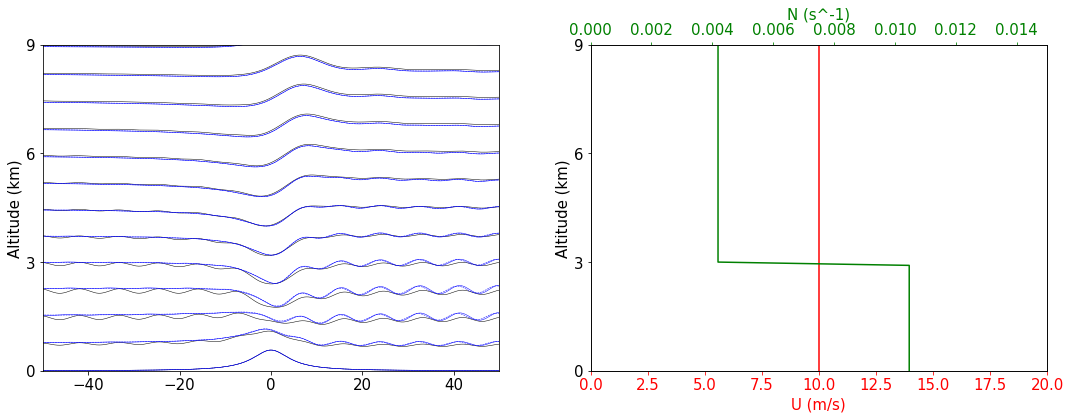

In [9]:
_,(ax1,ax2)=plt.subplots(1,2,figsize=(18,6));ax22=ax2.twiny()

plot_streamlines(ax1,w_general,10,color='k',linewidth=0.5)
plot_streamlines(ax1,w_general_destructive,10,color='b',linewidth=0.5)

#plot_streamlines(ax1,w_2layer,10,color='k',linewidth=0.5,linestyle='--')
plot_streamlines(ax1,w_2layer_destructive,10,color='b',linewidth=0.5,linestyle='--')

ax2.plot(Uz0,z/1e3,color='red')
ax22.plot(Nz0,z/1e3,color='green')

ax2.tick_params(axis='x', colors='r'); ax2.set_xlabel('U (m/s)',color='r')
ax22.tick_params(axis='x', colors='g');ax22.set_xlabel('N (s^-1)',color='g')
for ax in ax1,ax2:
    ax.set_yticks((0,3,6,9))
    ax.set_ylim(0,9)
    ax.set_ylabel("Altitude (km)")
    
ax1.set_xlim(-50,50)
ax2.set_xlim(0,20)
ax22.set_xlim(0,0.015)

(-100.0, 100.0)

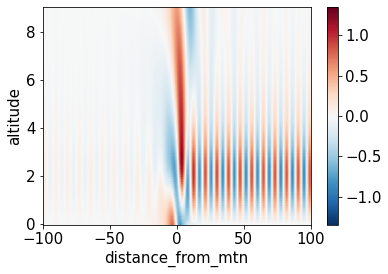

In [10]:
w_general_destructive.plot(y='altitude')
plt.xlim(-100,100)

(-100.0, 100.0)

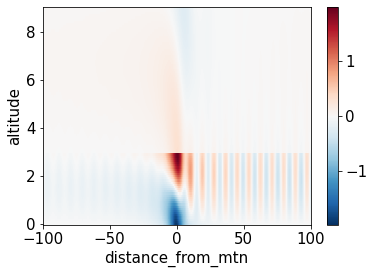

In [11]:
w_to_Tprime(w_general_destructive,Uz0,Nz0).plot(y='altitude')
plt.xlim(-100,100)

(-100.0, 100.0)

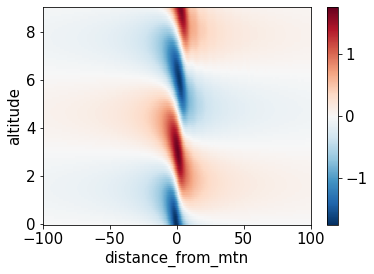

In [12]:
w_test = linear_w_1layer(xx,hx,z,10,0.01)
w_to_Tprime(w_test,10,0.01).plot(y='altitude')
plt.xlim(-100,100)

In [19]:
import matplotlib.pyplot as plt
import xarray as xr
xr.set_options(display_style='text')

(1500.0, 2000.0)

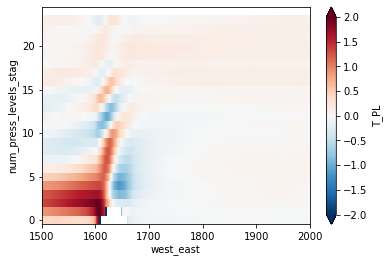

In [22]:
test = xr.open_dataset('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.500m.9mps.3km/diags/wrf.T_PL.days50-400.nc').T_PL
test=test.where(test>200)
(test-test.isel(west_east=3000)).plot(vmin=-2,vmax=2,cmap=plt.cm.RdBu_r)
plt.xlim(1500,2000)

# With WRF stability profile

In [2]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile
from orographicPrecipitation.observationsAndERA5.linearWaveModels import linear_w_1layer,z_to_p_standard
from tools.generalTools import compute_N
from tools.wrfHrTools import change_coords_pl
from scipy.interpolate import interp1d

In [3]:
xx,hx = topographic_profile('cos',A=500)
xx = xx[1000:3001]
hx = hx[1000:3001]

In [4]:
sample_pout = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.new.3km/wrfpout_d01_1970-03-17_01_00_00")
T_all = change_coords_pl(sample_pout,sample_pout.T_PL).sel(distance_from_mtn=slice(-2000,-5000))
T_mean = T_all.where(T_all>0).mean(['Time','south_north','distance_from_mtn'])

Z_all = change_coords_pl(sample_pout,sample_pout.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
Z_mean = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])

w_all = change_coords_pl(sample_pout,sample_pout.W_PL)
w_mean = w_all.where(w_all>-100).mean(['Time','south_north'])

In [5]:
z=np.linspace(0,20e3,100)
p = interp1d(Z_mean,T_mean.pressure,kind='linear',fill_value='extrapolate')(z)
N = interp1d(Z_mean,compute_N(T_mean,100,'pressure'),kind='linear',fill_value='extrapolate')(z)
U = 10.*z**0

In [6]:
%time w_general = linear_w_generalized(xx,hx,z,U,N)
%time w_linear  = linear_w_1layer(xx,hx,z,U.mean(),N[:len(N)//2].mean())

0 500 1000 1500 2000 CPU times: user 1.04 s, sys: 29 ms, total: 1.07 s
Wall time: 1.16 s
CPU times: user 19 ms, sys: 3.4 ms, total: 22.4 ms
Wall time: 22.3 ms


In [7]:
w_general = w_general.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})
w_linear  = w_linear .assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})

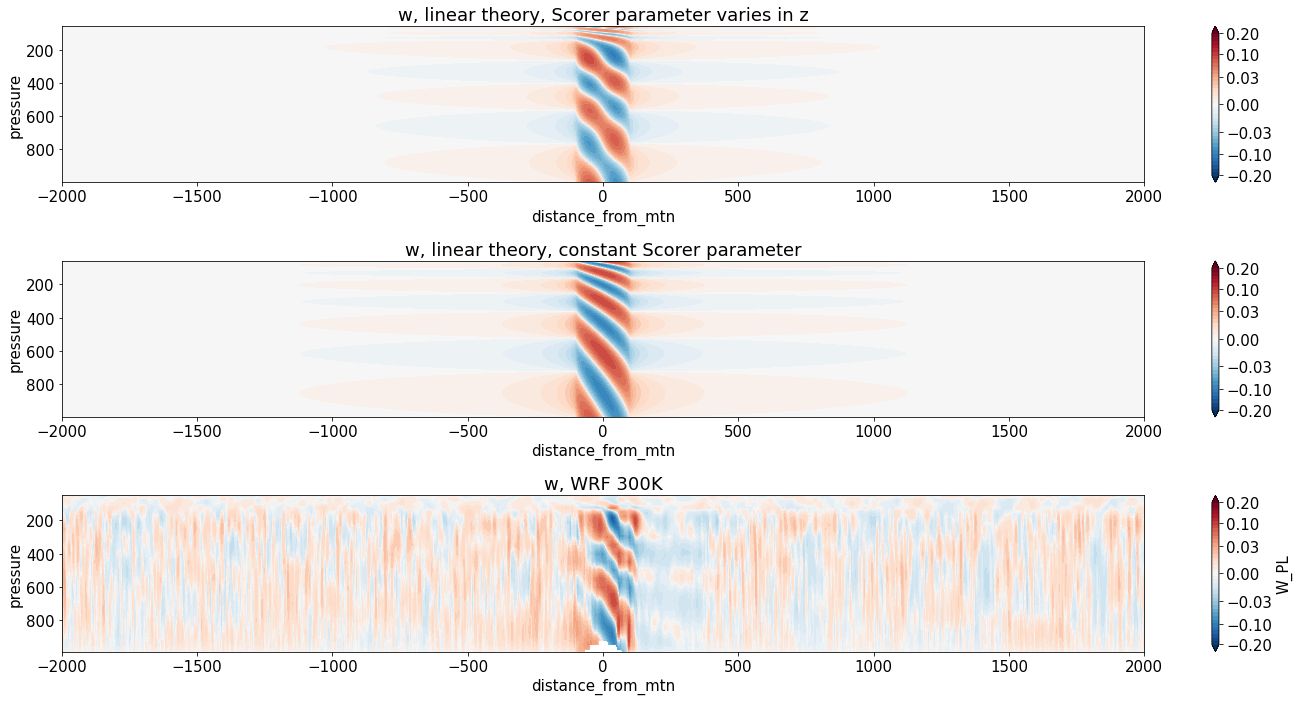

In [8]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
amp=0.03
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

w_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_linear.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_mean.plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
axs[0].set_title('w, linear theory, Scorer parameter varies in z')
axs[1].set_title('w, linear theory, constant Scorer parameter')
axs[2].set_title('w, WRF 300K')
fig.tight_layout()

In [10]:
%%time
sample_pout296 = xr.open_dataset("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.296K.new.3km/BAKwrfpout_d01_1970-10-18_00_00_00")
T_all = change_coords_pl(sample_pout296,sample_pout296.T_PL).sel(distance_from_mtn=slice(-2000,-5000))
T_mean296 = T_all.where(T_all>0).mean(['Time','south_north','distance_from_mtn'])
Z_all = change_coords_pl(sample_pout296,sample_pout296.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
Z_mean296 = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])
w_all = change_coords_pl(sample_pout296,sample_pout296.W_PL)
w_mean296 = w_all.where(w_all>-100).mean(['Time','south_north'])


CPU times: user 18.8 s, sys: 37.9 s, total: 56.7 s
Wall time: 1min 4s


In [11]:
p296 = interp1d(Z_mean296,T_mean296.pressure,kind='linear',fill_value='extrapolate')(z)
N296 = interp1d(Z_mean296,compute_N(T_mean296,100,'pressure'),kind='linear',fill_value='extrapolate')(z)
U = 10.*z**0

In [12]:
%time w_general296 = linear_w_generalized(xx,hx,z,U,N296)

0 500 1000 1500 2000 CPU times: user 1.13 s, sys: 8.81 ms, total: 1.14 s
Wall time: 1.14 s


In [13]:
w_general296 = w_general296.assign_coords({'pressure':('altitude',p296)}).swap_dims({'altitude':'pressure'})

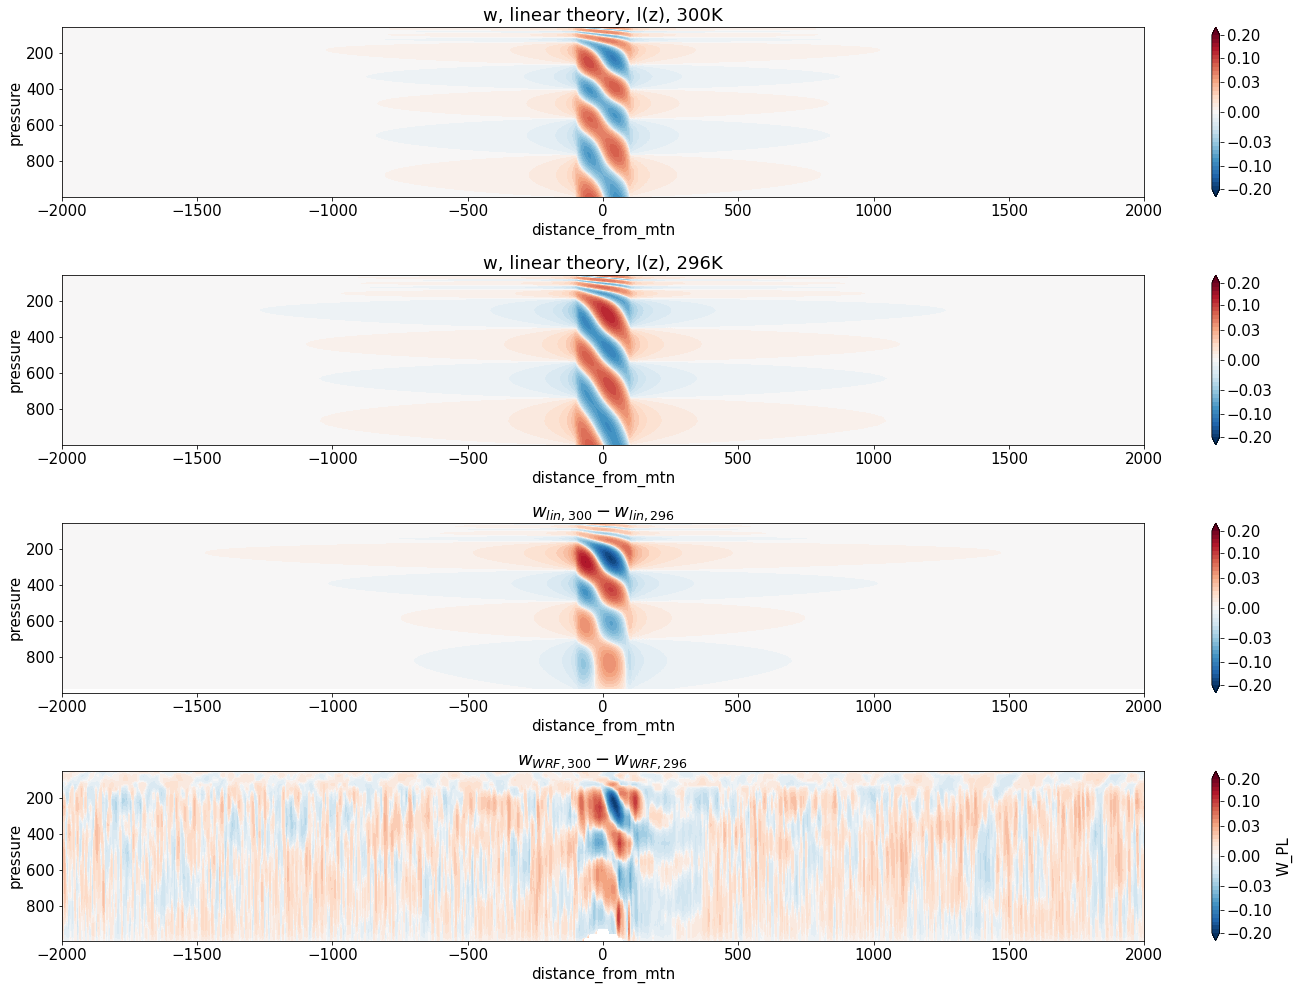

In [ ]:
fig,axs = plt.subplots(4,1,figsize=(20,14))
amp=0.03
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

w_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_general296.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

(w_general-w_general296.interp_like(w_general)).plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
(w_mean-w_mean296).plot.contourf(ax=axs[3],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
axs[0].set_title('w, linear theory, l(z), 300K')
axs[1].set_title('w, linear theory, l(z), 296K')
axs[2].set_title(r'$w_{lin,300} - w_{lin,296}$')
axs[3].set_title(r'$w_{WRF,300} - w_{WRF,296}$')
fig.tight_layout()

In [26]:
from tools.generalTools import qsat

In [62]:
qs = qsat(T_mean,T_mean.pressure).assign_coords({'altitude':Z_mean})
dqsqz = qs.differentiate('altitude')
qs296 = qsat(T_mean296,T_mean296.pressure).assign_coords({'altitude':Z_mean296})
dqs296qz = qs296.differentiate('altitude')

In [64]:
CR_mmdy = (w_general*dqsqz.interp_like(w_general.pressure).fillna(-8.29982179e-06)).integrate('pressure')*100/9.81 * 86400
CR_mmdy296 = (w_general296*dqs296qz.interp_like(w_general296.pressure).fillna(-6.33240521e-06)).integrate('pressure')*100/9.81 * 86400

(-2000.0, 2000.0)

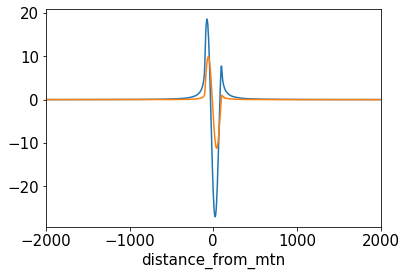

In [65]:
CR_mmdy296.plot()
CR_mmdy.plot()
plt.xlim(-2000,2000)

In [58]:
from orographicConvectionTheory.orographicConvectionTheory import smith_theory

In [72]:
xx2,_,Plin_smith = smith_theory(xx,hx,10,5.5e-3,4.32e-3)

using dry stability, N=0.012 s^-1


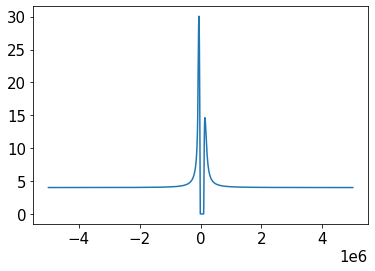

In [73]:
plt.plot(xx2,Plin_smith,)

## Forced GW mode

In [131]:
from linearWaveModels import second_derivative_matrix,k_vector

def gw_mode_forced(z,lz2,k,hhatk,U0,qhatk):
    """Computes one wave mode by solving the linear wave equation:
    d2/dz2(w_hat) + (l(z)^2-k^2)w_hat = 0, subject to BCs
    w_hat(k,z=0) = ikU(z=0)h_hat(k) 
    & d w_hat(k,ztop) = i m(ztop) w_hat(k,ztop), where m(ztop) is defined to satisfy a radiation BC or an evanescent BC at the top
    """
    n = len(z)
    dz = z[1]-z[0]
    
    sgnk = np.sign(k)
    if k==0:
        sgnk=1
    if lz2[-1] < k**2:
        mtop = 1j*np.sqrt(k**2-lz2[-1])
    else:
        mtop = sgnk*np.sqrt(lz2[-1]-k**2)
    
    D2 = second_derivative_matrix(n,1) #Matrix of second differentiation
    A = D2 + dz**2*np.diag(lz2-k**2)
    A = A.astype('complex')
    
    A[0]   = np.zeros(n)
    A[0,0] = 1
    A[-1]  = np.zeros(n)
    #A[-1,-1] = 1;A[-1,-2] = -1
    A[-1,-3:] = np.array([1,-4,3])/2
    A[-1,-1] -= dz * 1j* mtop
    
    b = 1j*np.zeros(n)
    b[0] = 1j*k*U0*hhatk
    b[1:-1]= qhatk[1:-1]
    
    return np.linalg.solve(A,b)
    A = csc_matrix(A)
    return spsolve(A,b)
    
def linear_w_generalized_forced(xx,hx,z,Uz,Nz,qxz):
    "z must be evenly spaced"
    kk=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    lz2 = Nz**2/Uz**2 - 1/Uz * np.dot(second_derivative_matrix(len(z),z[1]-z[0]),Uz)
    qhatz = np.fft.fft(qxz,axis=0)
    
    w_hat =np.zeros((len(kk),len(z)))*1j
    for i,k in enumerate(kk):
        if i%500==0:
            print(i,end=' ')
        w_hat[i] = gw_mode_forced(z,lz2,k,h_hat[i],Uz[0],qhatz[i,:])
        
    w=xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))})
    return w



In [132]:
q_diab = w_general**0*np.exp(-((w_general.distance_from_mtn+50)**2/2/30**2 + (w_general.pressure-750.)**2/50**2))

In [133]:
%time w_general_forced = linear_w_generalized_forced(xx,hx,z,U,N,np.array(q_diab)/86400*50)
w_general_forced =w_general_forced.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})


0 500 1000 1500 2000 CPU times: user 919 ms, sys: 1.4 ms, total: 921 ms
Wall time: 918 ms


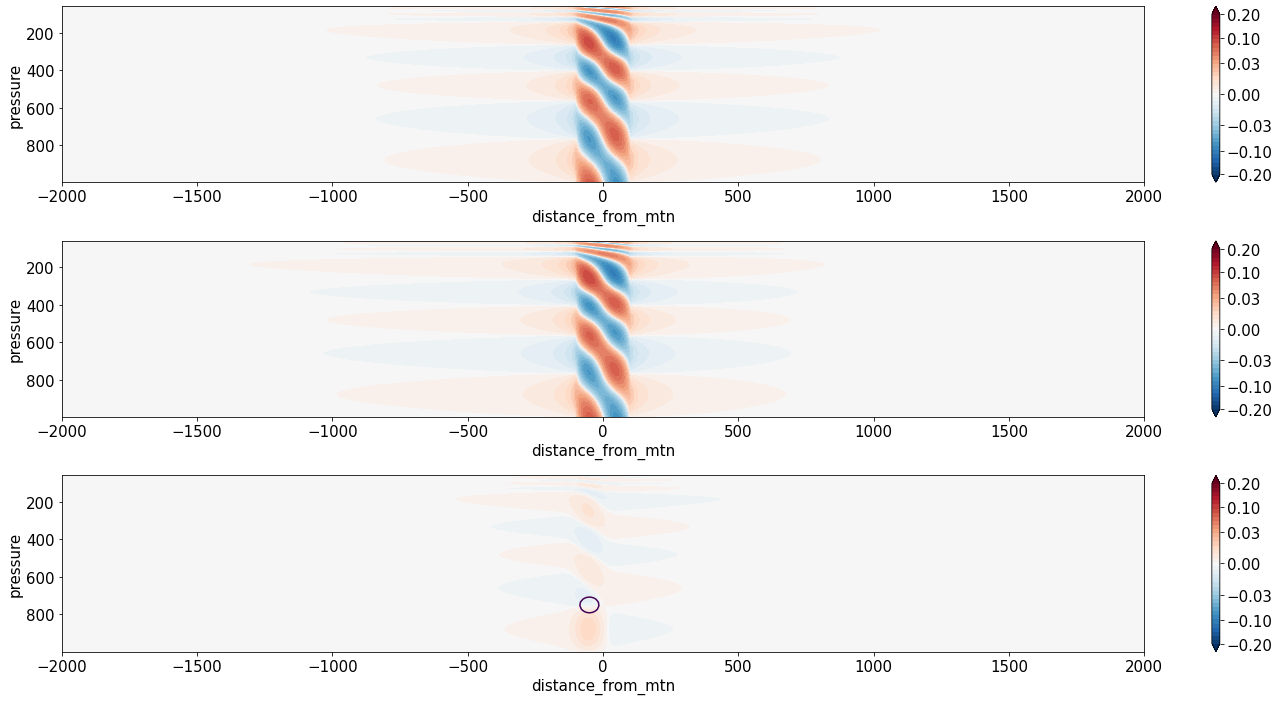

In [134]:
fig,axs = plt.subplots(3,1,figsize=(20,10))
amp=0.03
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

w_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_general_forced.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
(w_general_forced-w_general).plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
q_diab.plot.contour(ax=axs[2],levels=[0.5],y='pressure',yincrease=False)

for ax in axs:
    ax.set_xlim(-2000,2000)
#axs[0].set_title('w, linear theory, Scorer parameter varies in z')
#axs[1].set_title('w, linear theory, constant Scorer parameter')
#axs[2].set_title('w, WRF 300K')
fig.tight_layout()

In [ ]:
## Diagnose diabatic heating from the simulations and add in there to see how that modifies the precip

